In [6]:
# Adapted from the tutorial at https://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/

In [7]:
import torch
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
#logging.basicConfig(level=logging.INFO)

import matplotlib.pyplot as plt
%matplotlib inline

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [13]:
# list(tokenizer.vocab.keys())[5000:5020]
list(tokenizer.vocab.keys())[17733]

'disgusted'

In [47]:
# Define a new example sentence with multiple meanings of the word "disgusted"
text = "[CLS] She made a disgusted pout [SEP] Her disgusted expression was contagious [SEP]"

# Split the sentence into tokens.
tokenized_text = tokenizer.tokenize(text)
print(tokenized_text)

# Map the token strings to their vocabulary indeces.
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

# Display the words with their indeces.
for tup in zip(tokenized_text, indexed_tokens):
    print('{:<12} {:>6,}'.format(tup[0], tup[1]))

['[CLS]', 'she', 'made', 'a', 'disgusted', 'po', '##ut', '[SEP]', 'her', 'disgusted', 'expression', 'was', 'con', '##tag', '##ious', '[SEP]']
[CLS]           101
she           2,016
made          2,081
a             1,037
disgusted    17,733
po           13,433
##ut          4,904
[SEP]           102
her           2,014
disgusted    17,733
expression    3,670
was           2,001
con           9,530
##tag        15,900
##ious        6,313
[SEP]           102


In [43]:
# Convert inputs to PyTorch tensors
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-uncased')

# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): BertLayerNorm()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): BertLayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (intermediate): BertIntermediate(
          (dense): Lin

In [20]:
# Predict hidden states features for each layer
with torch.no_grad():
    encoded_layers, _ = model(tokens_tensor, segments_tensors)

In [21]:
print ("Number of layers:", len(encoded_layers))
layer_i = 0

print ("Number of batches:", len(encoded_layers[layer_i]))
batch_i = 0

print ("Number of tokens:", len(encoded_layers[layer_i][batch_i]))
token_i = 1

print ("Number of hidden units:", len(encoded_layers[layer_i][batch_i][token_i]))

Number of layers: 12
Number of batches: 1
Number of tokens: 3
Number of hidden units: 768


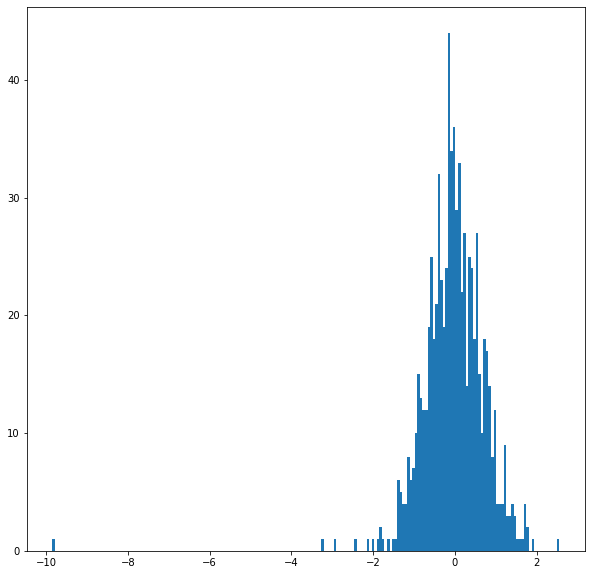

In [44]:
# For our token, select its feature values from layer 5.
token_i = 1
layer_i = 5
vec = encoded_layers[layer_i][batch_i][token_i]
# print(vec)

# Plot the values as a histogram to show their distribution.
plt.figure(figsize=(10,10))
plt.hist(vec, bins=200)
plt.show()

In [23]:
# `encoded_layers` is a Python list.
print('     Type of encoded_layers: ', type(encoded_layers))

# Each layer in the list is a torch tensor.
print('Tensor shape for each layer: ', encoded_layers[0].size())

     Type of encoded_layers:  <class 'list'>
Tensor shape for each layer:  torch.Size([1, 3, 768])


In [24]:
# Concatenate the tensors for all layers. We use `stack` here to
# create a new dimension in the tensor.
token_embeddings = torch.stack(encoded_layers, dim=0)

token_embeddings.size()

torch.Size([12, 1, 3, 768])

In [25]:
# Remove dimension 1, the "batches".
token_embeddings = torch.squeeze(token_embeddings, dim=1)

token_embeddings.size()

torch.Size([12, 3, 768])

In [26]:
# Swap dimensions 0 and 1.
token_embeddings = token_embeddings.permute(1,0,2)

token_embeddings.size()

torch.Size([3, 12, 768])

In [28]:
# Concatenate the last 4 hidden layers to create word embeddings.
# Stores the token vectors, with shape [22 x 3,072]
token_vecs_cat = []

# `token_embeddings` is a [22 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:
    
    # `token` is a [12 x 768] tensor

    # Concatenate the vectors (that is, append them together) from the last 
    # four layers.
    # Each layer vector is 768 values, so `cat_vec` is length 3,072.
    cat_vec = torch.cat((token[-1], token[-2], token[-3], token[-4]), dim=0)
    
    # Use `cat_vec` to represent `token`.
    token_vecs_cat.append(cat_vec)

print ('Shape is: %d x %d' % (len(token_vecs_cat), len(token_vecs_cat[0])))
print(token_vecs_cat[0])

Shape is: 3 x 3072
tensor([-0.0637,  0.3612, -0.0899,  ..., -0.4850, -0.3801,  0.8791])


In [29]:
# Sum the last 4 hidden layers to create word embeddings.
# Stores the token vectors, with shape [22 x 768]
token_vecs_sum = []

# `token_embeddings` is a [22 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:

    # `token` is a [12 x 768] tensor

    # Sum the vectors from the last four layers.
    sum_vec = torch.sum(token[-4:], dim=0)
    
    # Use `sum_vec` to represent `token`.
    token_vecs_sum.append(sum_vec)

print ('Shape is: %d x %d' % (len(token_vecs_sum), len(token_vecs_sum[0])))

Shape is: 3 x 768


In [30]:
# Concatenate the last 4 hidden layers to create word embeddings.
# Stores the token vectors, with shape [22 x 3,072]
token_vecs_cat_first = []

# `token_embeddings` is a [22 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:
    
    # `token` is a [12 x 768] tensor

    # Concatenate the vectors (that is, append them together) from the last 
    # four layers.
    # Each layer vector is 768 values, so `cat_vec` is length 3,072.
    cat_vec = torch.cat((token[0], token[1], token[2], token[3]), dim=0)
    
    # Use `cat_vec` to represent `token`.
    token_vecs_cat_first.append(cat_vec)

print ('Shape is: %d x %d' % (len(token_vecs_cat_first), len(token_vecs_cat_first[0])))
print(token_vecs_cat[0])

Shape is: 3 x 3072
tensor([-0.0637,  0.3612, -0.0899,  ..., -0.4850, -0.3801,  0.8791])


In [31]:
# Sum the last 4 hidden layers to create word embeddings.
# Stores the token vectors, with shape [22 x 768]
token_vecs_sum_first = []

# `token_embeddings` is a [22 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:

    # `token` is a [12 x 768] tensor

    # Sum the vectors from the last four layers.
    sum_vec = torch.sum(token[:4], dim=0)
    
    # Use `sum_vec` to represent `token`.
    token_vecs_sum_first.append(sum_vec)

print ('Shape is: %d x %d' % (len(token_vecs_sum_first), len(token_vecs_sum_first[0])))

Shape is: 3 x 768


In [32]:
# Concatenate the last 4 hidden layers to create word embeddings.
# Stores the token vectors, with shape [22 x 3,072]
token_vecs_cat_middle1 = []

# `token_embeddings` is a [22 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:
    
    # `token` is a [12 x 768] tensor

    # Concatenate the vectors (that is, append them together) from the last 
    # four layers.
    # Each layer vector is 768 values, so `cat_vec` is length 3,072.
    cat_vec = torch.cat((token[4], token[5], token[6], token[7]), dim=0)
    
    # Use `cat_vec` to represent `token`.
    token_vecs_cat_middle1.append(cat_vec)

print ('Shape is: %d x %d' % (len(token_vecs_cat_middle1), len(token_vecs_cat_middle1[0])))
print(token_vecs_cat[0])

Shape is: 3 x 3072
tensor([-0.0637,  0.3612, -0.0899,  ..., -0.4850, -0.3801,  0.8791])


In [33]:
# Sum the last 4 hidden layers to create word embeddings.
# Stores the token vectors, with shape [22 x 768]
token_vecs_sum_middle1 = []

# `token_embeddings` is a [22 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:

    # `token` is a [12 x 768] tensor

    # Sum the vectors from the last four layers.
    sum_vec = torch.sum(token[4:8], dim=0)
    
    # Use `sum_vec` to represent `token`.
    token_vecs_sum_middle1.append(sum_vec)

print ('Shape is: %d x %d' % (len(token_vecs_sum_middle1), len(token_vecs_sum_middle1[0])))

Shape is: 3 x 768


In [34]:
# Concatenate the last 4 hidden layers to create word embeddings.
# Stores the token vectors, with shape [22 x 3,072]
token_vecs_cat_middle2 = []

# `token_embeddings` is a [22 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:
    
    # `token` is a [12 x 768] tensor

    # Concatenate the vectors (that is, append them together) from the last 
    # four layers.
    # Each layer vector is 768 values, so `cat_vec` is length 3,072.
    cat_vec = torch.cat((token[8], token[9], token[10], token[11]), dim=0)
    
    # Use `cat_vec` to represent `token`.
    token_vecs_cat_middle2.append(cat_vec)

print ('Shape is: %d x %d' % (len(token_vecs_cat_middle2), len(token_vecs_cat_middle2[0])))
print(token_vecs_cat[0])

Shape is: 3 x 3072
tensor([-0.0637,  0.3612, -0.0899,  ..., -0.4850, -0.3801,  0.8791])


In [35]:
# Sum the last 4 hidden layers to create word embeddings.
# Stores the token vectors, with shape [22 x 768]
token_vecs_sum_middle2 = []

# `token_embeddings` is a [22 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:

    # `token` is a [12 x 768] tensor

    # Sum the vectors from the last four layers.
    sum_vec = torch.sum(token[8:], dim=0)
    
    # Use `sum_vec` to represent `token`.
    token_vecs_sum_middle2.append(sum_vec)

print ('Shape is: %d x %d' % (len(token_vecs_sum_middle2), len(token_vecs_sum_middle2[0])))

Shape is: 3 x 768


In [36]:
# Concatenate the last 4 hidden layers to create word embeddings.
# Stores the token vectors, with shape [22 x 3,072]
token_vecs_cat_all = []

# `token_embeddings` is a [22 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:
    
    # `token` is a [12 x 768] tensor

    # Concatenate the vectors (that is, append them together) from the last 
    # four layers.
    # Each layer vector is 768 values, so `cat_vec` is length 3,072.
    cat_vec = torch.cat((token[0], token[1], token[2], token[3], token[4], token[5], token[6], token[7], token[8], token[9], token[10], token[11]), dim=0)
    
    # Use `cat_vec` to represent `token`.
    token_vecs_cat_all.append(cat_vec)

print ('Shape is: %d x %d' % (len(token_vecs_cat_all), len(token_vecs_cat_all[0])))
print(token_vecs_cat[0])

Shape is: 3 x 9216
tensor([-0.0637,  0.3612, -0.0899,  ..., -0.4850, -0.3801,  0.8791])


In [37]:
# Sum the last 4 hidden layers to create word embeddings.
# Stores the token vectors, with shape [22 x 768]
token_vecs_sum_all = []

# `token_embeddings` is a [22 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:

    # `token` is a [12 x 768] tensor

    # Sum the vectors from the last four layers.
    sum_vec = torch.sum(token[:], dim=0)
    
    # Use `sum_vec` to represent `token`.
    token_vecs_sum_all.append(sum_vec)

print ('Shape is: %d x %d' % (len(token_vecs_sum_all), len(token_vecs_sum_all[0])))

Shape is: 3 x 768


In [38]:
# Make a single vector to represent the pair of sentences by averaging across tokens.
# `encoded_layers` has shape [12 x 1 x 22 x 768]
sentences_vec = []
# `token_vecs` is a tensor with shape [22 x 768]
token_vecs = encoded_layers[11][0]

# Calculate the average of all 22 token vectors.
sentence_embedding = torch.mean(token_vecs, dim=0)
for s in sentence_embedding:
    sentences_vec.append(s)
print ("Our final sentence embedding vector of shape:", sentence_embedding.size())
print(sentence_embedding[767])
print(sentence_embedding[-1])
print(f'Shape of sentences vector is: {len(sentences_vec)}')
print(sentences_vec[-1])

Our final sentence embedding vector of shape: torch.Size([768])
tensor(-0.1680)
tensor(-0.1680)
Shape of sentences vector is: 768
tensor(-0.1680)


In [ ]:
--------------------------------------------------------------------------------------
BEGIN TESTING STATIC CONTEXTUAL EMBEDDING CREATION
--------------------------------------------------------------------------------------

In [49]:
# We want to create a static context embedding for a single vocabulary word.
word = "disgusted"

# Add the special tokens.
marked_text = "[CLS] " + word + " [SEP]"

# Split the sentence into tokens.
# tokenized_text = tokenizer.tokenize(marked_text)
tokenized_text = tokenizer.tokenize(marked_text)
print(tokenized_text)

# Map the token strings to their vocabulary indeces.
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

# Display the words with their indeces.
for tup in zip(tokenized_text, indexed_tokens):
    print('{:<12} {:>6,}'.format(tup[0], tup[1]))

['[CLS]', 'disgusted', '[SEP]']
[CLS]           101
disgusted    17,733
[SEP]           102


In [50]:
# Mark each of the tokens as belonging to sentence "0" or "1".
# segments_ids = [1] * len(tokenized_text)
segments_ids = [0,0,0]
print (segments_ids)
print(indexed_tokens)
print(tokenized_text[1])

[0, 0, 0]
[101, 17733, 102]
disgusted


In [51]:
for i, token_string in enumerate(tokenized_text):
    print(i, token_string)

0 [CLS]
1 disgusted
2 [SEP]


In [52]:
from scipy.spatial.distance import cosine
# Test the similarity of a word with itself.
# For words trained contextually, self-synonymy is less than 1.
similarity = 1 - cosine(token_vecs_cat[1], token_vecs_cat[1])
print(f'Similarity of {tokenized_text[1]} and {tokenized_text[1]} in token_vecs_cat is: {similarity}')
# similarity = 1 - cosine(token_vecs_sum[4], token_vecs_sum[9])
# print(f'Similarity of {tokenized_text[4]} and {tokenized_text[9]} in token_vecs_sum is: {similarity}')
# similarity = 1 - cosine(token_vecs_cat_first[4], token_vecs_cat_first[9])
# print(f'Similarity of {tokenized_text[4]} and {tokenized_text[9]} in token_vecs_cat_first is: {similarity}')
# similarity = 1 - cosine(token_vecs_sum_first[4], token_vecs_sum_first[9])
# print(f'Similarity of {tokenized_text[4]} and {tokenized_text[9]} in token_vecs_sum_first is: {similarity}')
# similarity = 1 - cosine(token_vecs_cat_middle1[4], token_vecs_cat_middle1[9])
# print(f'Similarity of {tokenized_text[4]} and {tokenized_text[9]} in token_vecs_cat_middle1 is: {similarity}')
# similarity = 1 - cosine(token_vecs_sum_middle1[4], token_vecs_sum_middle1[9])
# print(f'Similarity of {tokenized_text[4]} and {tokenized_text[9]} in token_vecs_sum_middle1 is: {similarity}')
# similarity = 1 - cosine(token_vecs_cat_middle2[4], token_vecs_cat_middle2[9])
# print(f'Similarity of {tokenized_text[4]} and {tokenized_text[9]} in token_vecs_cat_middle2 is: {similarity}')
# similarity = 1 - cosine(token_vecs_sum_middle2[4], token_vecs_sum_middle2[9])
# print(f'Similarity of {tokenized_text[4]} and {tokenized_text[9]} in token_vecs_sum_middle2 is: {similarity}')
# similarity = 1 - cosine(token_vecs_cat_all[4], token_vecs_cat_all[9])
# print(f'Similarity of {tokenized_text[4]} and {tokenized_text[9]} in token_vecs_cat_all is: {similarity}')
# similarity = 1 - cosine(token_vecs_sum_all[4], token_vecs_sum_all[9])
# print(f'Similarity of {tokenized_text[4]} and {tokenized_text[9]} in token_vecs_sum_all is: {similarity}')

Similarity of disgusted and disgusted in token_vecs_cat is: 1.0
